In [91]:
import matplotlib.pyplot as plt

# 設定中文字型 (Windows 使用微軟正黑體, Mac 使用 Arial Unicode MS)
import platform
if platform.system() == 'Windows':
    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
else:
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

plt.rcParams['axes.unicode_minus'] = False # 解決負號顯示問題

#### 載入外部程式庫

anaconda 需額外載入
> tensorflow

> catboost

In [92]:
import pandas as pd
from pandas.testing import assert_frame_equal # panda 檢查
# model
from src.data_processing import DataProcessor
# Evaluater
import sys
import os


#### 準備資料集

##### Load csv


In [93]:
entities_path = {
     "T1"   :   "../DataSet/preprocessing_T1_basic.csv"
    ,"T12"  :   "../DataSet/preprocessing_T1_2.csv"
    ,"T123" :   "../DataSet/preprocessing_T1_2_3.csv"
}
entities = {}

# Load preprocessing and cut 
for index, path in entities_path.items():
    entities[index] = pd.read_csv(path)

print("原始資料：")
for v in entities.values():
    print(f"{v.head()}\n\n")

原始資料：
                                                acct  txn_count  first_txn_ts  \
0  00000577cfcd0bde8ee693021419ef13a1f7f933ec8626...          1       1953000   
1  00000eec52ea49377de91bc7b54eb3192943e6c20e0a51...          1       4489500   
2  000015150c92e2a41c4715a088df78d77a7d4f3017aadc...          1       5823000   
3  00002846e6b430580825e2b10fe3ff1e3ddb93f42c608d...          1       1100100   
4  00002b3d8f9c7b91c407a5725849deb521fcf1dd5eea1f...          1        777300   

   last_txn_ts  std_txn_ts  acct_type_x  cross_type    uni_amt  acct_type_y  \
0      1953000         0.0            2           1    47500.0            2   
1      4489500         0.0            2           1     6150.0            2   
2      5823000         0.0            2           1  1150000.0            2   
3      1100100         0.0            2           1     8550.0            2   
4       777300         0.0            2           1     1450.0            2   

   num_unique_dest_accts  num_un

##### Cut acct ID

In [94]:
# Cut preprocessing
entities_id = pd.DataFrame()

for index, entity in entities.items():
    id = entity.iloc[:,[0]]
    entities[index] = entity.iloc[:,1:]

    # 判斷entity id 是否相同
    if entities_id.empty:
        entities_id = id
    else :
        try:
            assert_frame_equal(entities_id, id)
        except AssertionError as e:
            print(f"Data ID error : from {index}")
            print(e)

print("資料ID :")
entities_id.head()

資料ID :


,acct
0,00000577cfcd0bde8ee693021419ef13a1f7f933ec8626...
1,00000eec52ea49377de91bc7b54eb3192943e6c20e0a51...
2,000015150c92e2a41c4715a088df78d77a7d4f3017aadc...
3,00002846e6b430580825e2b10fe3ff1e3ddb93f42c608d...
4,00002b3d8f9c7b91c407a5725849deb521fcf1dd5eea1f...


#### 建立 Evaluater評分 (結果產出)

In [95]:
def get_evaluater_score(model,X_train, X_test, y_train, y_test):
    # 假設您的環境設定
    sys.path.append(os.path.dirname(os.getcwd()))
    from Util import Evaluater

    Evaluater.evaluate_model(model, (X_train, X_test, y_train, y_test))

#### 建立繪圖程式 -> 回傳最佳切分點

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# 新增 filename 參數，預設存為 pr_curve.png
def plot_pr_curve_with_best_point(model, X_test, y_test, filename='pr_curve.png'):
    """
    繪製 LightGBM PR Curve 並標記 F1-Score 最高的最佳閥值點，並匯出圖片。
    """
    # 1. 取得正類別機率
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    ap_score = average_precision_score(y_test, y_pred_prob)
    print(f"Average Precision (AP) Score: {ap_score:.4f}")

    # 2. 計算 Precision, Recall 與 Thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

    # 3. 計算 F1-Score 尋找最佳點
    numerator = 2 * precision * recall
    denominator = precision + recall
    
    # 避免分母為 0
    f1_scores = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator!=0)
    
    # 取得最大 F1-Score 的索引位置
    ix = np.argmax(f1_scores)
    
    # --- 安全性檢查 ---
    # precision_recall_curve 回傳的 precision/recall 長度會比 thresholds 多 1
    # 如果最佳點剛好是最後一個點 (Recall=0)，thresholds 會 index out of bounds，這裡做個保護
    if ix < len(thresholds):
        best_thresh = thresholds[ix]
    else:
        best_thresh = 1.0 # 極端情況

    best_f1 = f1_scores[ix]
    best_precision = precision[ix]
    best_recall = recall[ix]

    # 4. 計算 AP (Average Precision)
    ap_score = average_precision_score(y_test, y_pred_prob)

    # 5. 繪圖
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label=f'LightGBM (AP = {ap_score:.3f})', markersize=1)

    # --- 標記最佳點 ---
    plt.scatter(best_recall, best_precision, marker='o', color='black', s=100, label='Best Threshold', zorder=5)
    
    # 文字說明
    plt.annotate(f'Best F1={best_f1:.3f}\nThresh={best_thresh:.3f}', 
                 xy=(best_recall, best_precision), 
                 xytext=(best_recall - 0.2, best_precision - 0.2),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    # 基準線
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill', color='gray')

    plt.xlabel('Recall (召回率)')
    plt.ylabel('Precision (精確率)')
    plt.title('Precision-Recall Curve with Best Threshold')
    plt.legend()
    plt.grid(True)

    # 6. 匯出圖片 (關鍵修改)
    # bbox_inches='tight' 可確保標籤不會被切掉
    # dpi=300 設定高解析度
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"圖片已成功儲存至: {filename}")

    # 顯示圖片 (建議在 savefig 之後，以免畫布被清空)
    plt.show()
    plt.close() # 關閉畫布釋放記憶體
    
    # 7. 回傳最佳閥值
    print(f"【建議】最佳切分閥值 (Threshold): {best_thresh:.4f}")
    print(f"       對應 F1-Score: {best_f1:.4f}")
    print(f"       對應 Recall: {best_recall:.4f}, Precision: {best_precision:.4f}")
    
    return best_thresh

#### 實作 : 定義運行資料集(dict)

In [97]:
# entities 標籤 (dict)
entities_index = []
for index in entities:
    entities_index.append(index)

print(entities_index)

['T1', 'T12', 'T123']


In [98]:
#==== 實作引用資料參考上面 輸出 index ====#

#       這裡手動調整跑訓練的資料集(參考上方輸出)
#                       vv
train_entities_index =["T1","T12","T123"] #["T1"]
#                       ^^
#       這裡手動調整跑訓練的資料集(參考上方輸出)

#       這裡手動調整跑訓練的次數
#                  vv
model_train_turn = 50
#                  ^^
#       這裡手動調整跑訓練的次數

#### 實作 : 資料分析 ( AE + CatBoost )

In [99]:
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import train_test_split
sys.path.append(os.path.dirname(os.getcwd()))
from Util.PrepareData import prepare_data_pure,prepare_data_cutting,prepare_data_smote


In [100]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbose': -1,
    'n_jobs': -1,
    
    # --- 核心學習率 ---
    'learning_rate': 0.03,      # 調低學習率，讓模型學得更穩，避免快速過擬合
    'n_estimators': 1000,       # 樹的數量，建議搭配 early_stopping 使用
    
    # --- 抗過擬合 (重點調整區) ---
    'num_leaves': 20,           # 預設是 31，調小此值可大幅減少過擬合
    'max_depth': 6,             # 限制樹的深度，避免模型記住太多細節
    'min_child_samples': 50,    # 每個葉子節點最少要有 50 筆資料，避免針對少數噪聲學習
    
    # --- 正則化 ---
    'reg_alpha': 0.5,           # L1 正則化 (過濾沒用的特徵)
    'reg_lambda': 0.5,          # L2 正則化 (防止權重過大)
    
    # --- 樣本抽樣 ---
    'subsample': 0.8,           # 每次訓練只用 80% 的資料
    'colsample_bytree': 0.8,    # 每次訓練只用 80% 的特徵
    
    # --- 類別平衡 ---
    # is_unbalance=True,        # 千萬不要設 True，這會讓 Recall 很高但 Precision 很低
    'scale_pos_weight': 4,      # 手動設定權重。設為 1 會偏向 Precision；設越大越偏向 Recall。
                                # 試試 3 到 5 之間來抓取 P/R 的平衡點。
}


index = T1
訓練集大小: (129451, 12), 測試集大小: (54275, 12)
訓練集正類比例: 2.72%, 測試集正類比例: 0.55%
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[989]	valid_0's auc: 0.999602


c:\Users\1than\anaconda3\envs\data\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Average Precision (AP) Score: 0.7766
圖片已成功儲存至: T1.png


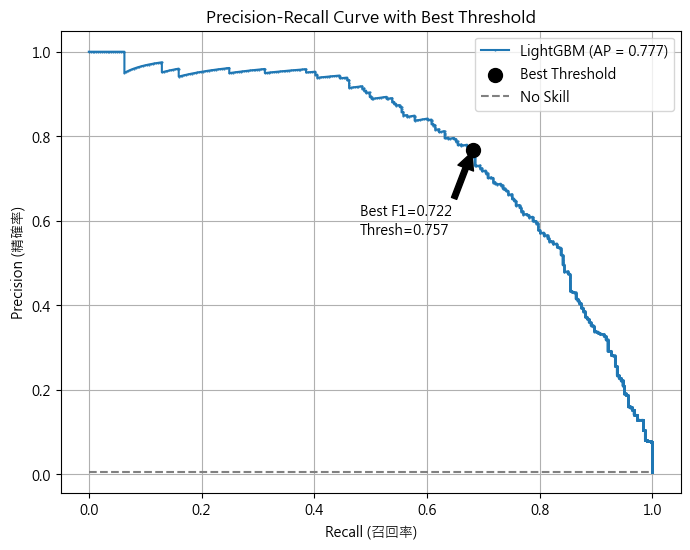

【建議】最佳切分閥值 (Threshold): 0.7569
       對應 F1-Score: 0.7218
       對應 Recall: 0.6811, Precision: 0.7678

--------------------------------------------------
evaluater 測試：
--------------------------------------------------


c:\Users\1than\anaconda3\envs\data\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\1than\anaconda3\envs\data\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\1than\anaconda3\envs\data\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\1than\anaconda3\envs\data\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


訓練資料集:
Confusion Matrix (using probabilities):
[[100659     89]
 [     7   2805]]

Classification Report (using probabilities):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    100748
           1       0.97      1.00      0.98      2812

    accuracy                           1.00    103560
   macro avg       0.98      1.00      0.99    103560
weighted avg       1.00      1.00      1.00    103560

Accuracy: 0.9991
ROC AUC Score: 1.0000
------------------------------------------------------------
測試資料集:
Confusion Matrix (using probabilities):
[[53839   135]
 [   71   230]]

Classification Report (using probabilities):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53974
           1       0.63      0.76      0.69       301

    accuracy                           1.00     54275
   macro avg       0.81      0.88      0.84     54275
weighted avg       1.00      1.00      1.00     5

c:\Users\1than\anaconda3\envs\data\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\1than\anaconda3\envs\data\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\1than\anaconda3\envs\data\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\1than\anaconda3\envs\data\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\1than\anaconda3\envs\data\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samp

訓練資料集:
Confusion Matrix (using probabilities):
[[100659     89]
 [     7   2805]]

Classification Report (using probabilities):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    100748
           1       0.97      1.00      0.98      2812

    accuracy                           1.00    103560
   macro avg       0.98      1.00      0.99    103560
weighted avg       1.00      1.00      1.00    103560

Accuracy: 0.9991
ROC AUC Score: 1.0000
------------------------------------------------------------
測試資料集:
Confusion Matrix (using probabilities):
[[  0   0]
 [ 71 230]]

Classification Report (using probabilities):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.76      0.87       301

    accuracy                           0.76       301
   macro avg       0.50      0.38      0.43       301
weighted avg       1.00      0.76      0.87       301

Ac

c:\Users\1than\anaconda3\envs\data\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Average Precision (AP) Score: 0.8187
圖片已成功儲存至: T12.png


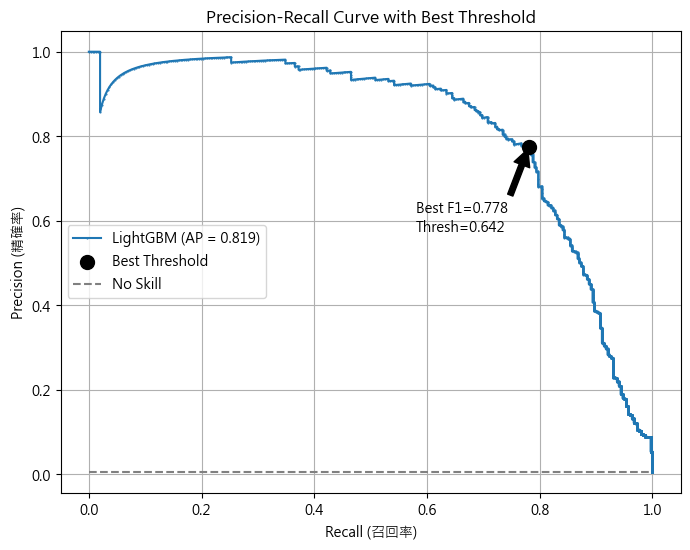

【建議】最佳切分閥值 (Threshold): 0.6418
       對應 F1-Score: 0.7781
       對應 Recall: 0.7807, Precision: 0.7756

--------------------------------------------------
evaluater 測試：
--------------------------------------------------


c:\Users\1than\anaconda3\envs\data\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\1than\anaconda3\envs\data\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\1than\anaconda3\envs\data\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\1than\anaconda3\envs\data\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


訓練資料集:
Confusion Matrix (using probabilities):
[[100642    106]
 [     7   2805]]

Classification Report (using probabilities):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    100748
           1       0.96      1.00      0.98      2812

    accuracy                           1.00    103560
   macro avg       0.98      1.00      0.99    103560
weighted avg       1.00      1.00      1.00    103560

Accuracy: 0.9989
ROC AUC Score: 1.0000
------------------------------------------------------------
測試資料集:
Confusion Matrix (using probabilities):
[[53873   101]
 [   61   240]]

Classification Report (using probabilities):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53974
           1       0.70      0.80      0.75       301

    accuracy                           1.00     54275
   macro avg       0.85      0.90      0.87     54275
weighted avg       1.00      1.00      1.00     5

c:\Users\1than\anaconda3\envs\data\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\1than\anaconda3\envs\data\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\1than\anaconda3\envs\data\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\1than\anaconda3\envs\data\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\1than\anaconda3\envs\data\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samp

訓練資料集:
Confusion Matrix (using probabilities):
[[100642    106]
 [     7   2805]]

Classification Report (using probabilities):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    100748
           1       0.96      1.00      0.98      2812

    accuracy                           1.00    103560
   macro avg       0.98      1.00      0.99    103560
weighted avg       1.00      1.00      1.00    103560

Accuracy: 0.9989
ROC AUC Score: 1.0000
------------------------------------------------------------
測試資料集:
Confusion Matrix (using probabilities):
[[  0   0]
 [ 61 240]]

Classification Report (using probabilities):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.80      0.89       301

    accuracy                           0.80       301
   macro avg       0.50      0.40      0.44       301
weighted avg       1.00      0.80      0.89       301

Ac

c:\Users\1than\anaconda3\envs\data\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Average Precision (AP) Score: 0.8466
圖片已成功儲存至: T123.png


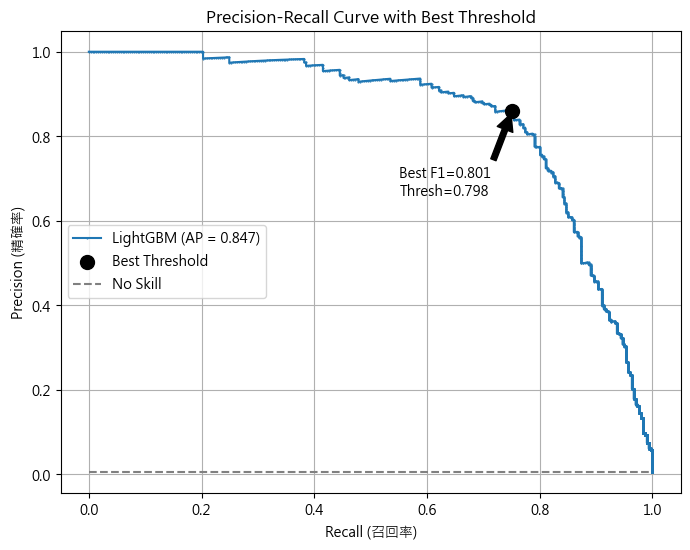

【建議】最佳切分閥值 (Threshold): 0.7984
       對應 F1-Score: 0.8014
       對應 Recall: 0.7508, Precision: 0.8593

--------------------------------------------------
evaluater 測試：
--------------------------------------------------


c:\Users\1than\anaconda3\envs\data\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\1than\anaconda3\envs\data\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\1than\anaconda3\envs\data\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\1than\anaconda3\envs\data\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


訓練資料集:
Confusion Matrix (using probabilities):
[[100675     73]
 [     6   2806]]

Classification Report (using probabilities):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    100748
           1       0.97      1.00      0.99      2812

    accuracy                           1.00    103560
   macro avg       0.99      1.00      0.99    103560
weighted avg       1.00      1.00      1.00    103560

Accuracy: 0.9992
ROC AUC Score: 1.0000
------------------------------------------------------------
測試資料集:
Confusion Matrix (using probabilities):
[[53880    94]
 [   56   245]]

Classification Report (using probabilities):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53974
           1       0.72      0.81      0.77       301

    accuracy                           1.00     54275
   macro avg       0.86      0.91      0.88     54275
weighted avg       1.00      1.00      1.00     5

c:\Users\1than\anaconda3\envs\data\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\1than\anaconda3\envs\data\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\1than\anaconda3\envs\data\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


訓練資料集:
Confusion Matrix (using probabilities):
[[100675     73]
 [     6   2806]]

Classification Report (using probabilities):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    100748
           1       0.97      1.00      0.99      2812

    accuracy                           1.00    103560
   macro avg       0.99      1.00      0.99    103560
weighted avg       1.00      1.00      1.00    103560

Accuracy: 0.9992
ROC AUC Score: 1.0000
------------------------------------------------------------
測試資料集:
Confusion Matrix (using probabilities):
[[  0   0]
 [ 56 245]]

Classification Report (using probabilities):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.81      0.90       301

    accuracy                           0.81       301
   macro avg       0.50      0.41      0.45       301
weighted avg       1.00      0.81      0.90       301

Ac

c:\Users\1than\anaconda3\envs\data\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\1than\anaconda3\envs\data\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\1than\anaconda3\envs\data\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\1than\anaconda3\envs\data\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set

In [101]:
for index in train_entities_index:
    print(f"\nindex = {index}")
    
    # 1. 初始化 LightGBM 模型
    # is_unbalance=True 是針對不平衡資料的關鍵參數
    model = lgb.LGBMClassifier(**params)
    
    entity = entities[index]

    # 切分訓練與測試資料(第一次切分 : 統一切分)
    X_train_full, X_test_final, y_train_full, y_test_final = prepare_data_cutting(entity)

    # -------------------------------------------------------------------------
    # [新增步驟] : 將 "訓練資料 (Full)" 再切分為 "真正訓練用 (Train)" 與 "驗證用 (Val)"
    # 建議比例：從訓練集中切出 20% 作為驗證集
    # stratify=y_train_full 非常重要！因為你的資料不平衡，必須確保驗證集也有 Label 1
    # -------------------------------------------------------------------------
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full,
        test_size=0.2,       # 切 20% 當驗證集
        random_state=42,     # 固定種子碼確保結果可重現
        stratify=y_train_full # 確保切分後的 Label 比例與原本一致
    )

    # 2. 訓練模型 (加入驗證集與早停機制)
    # 注意：新版 LightGBM 建議使用 callbacks 來處理 early_stopping
    # 建立模型

    # 訓練時建議加入 eval_set 來監控 (避免過度訓練)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        callbacks=[lgb.early_stopping(stopping_rounds=50)]
    )
    
    # 取得最佳閥值
    threshold = plot_pr_curve_with_best_point(model, X_test_final, y_test_final,f"{index}.png")

     # evaluater
    print ("\n"+"-"*50)
    print ("evaluater 測試：")
    print ("-"*50)
    get_evaluater_score(model,X_train, X_test_final, y_train, y_test_final)
        
    # 找回 label = 1 的準確度
    """
    - entity_label1 : 全部為 label 1 的資料集
    - X_label1, y_label1 : 從 entity_label1 切分出來的訓練資料 (All label 1)
    - X_test_label1, y__test_label1 : 從 X_test 切分出來的測試資料 (All label 1)
    """
    # All label 1
    entity_label1 = entity.copy()
    label,entity_label1_cut = DataProcessor.cut_label(entity_label1) # label -> enitiy的 label ; entity_label1_cut -> entity 移除 label 列 
    X_label1 = DataProcessor.split_diff_label(entity_label1_cut, label, positive_label=True) # label1 -> entity 移除 label 列並取 label = 1 (alert)
    y_label1 = pd.Series([1]*X_label1.shape[0]) # 全部為 1
    # no train label 1
    X_test_label1 = DataProcessor.split_diff_label(X_test_final, y_test_final, positive_label=True) # 從 X_test 切分出來的測試資料 (All label 1) 
    y_test_label1 = pd.Series([1]*X_test_label1.shape[0])

    # 確保 X_label1 是從正確的 X_test 篩選出來的，保留 DataFrame 格式
    mask = (y_test_final== 1)
    X_label1_correct = X_test_final[mask]  # 這樣會保留欄位名稱
    y_label1_correct = y_test_final[mask]    

    # 產生分數
    print ("\n"+"-"*50)
    print ("Label = 1 (alert) 的準確度：")
    print ("-"*50)
    get_evaluater_score(model, X_train, X_label1_correct, y_train, y_label1_correct)
        
